In [19]:
import os # The OS module in Python provides functions for interacting with the operating system
import tensorflow as tf # ML lib
from tensorflow.keras.preprocessing.image import ImageDataGenerator # multiply images
from tensorflow.keras.layers import Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.models import load_model, Sequential
import numpy as np # arithmatic calculations 
import matplotlib.pyplot as plt # draw graphs

### Constants

In [20]:
DATASET_DIR = './dataset/soil_types'
CLASSES = os.listdir(DATASET_DIR)
CLASSES.sort()
print(CLASSES)

['Black Soil', 'Cinder Soil', 'Laterite Soil', 'Peat Soil', 'Yellow Soil']


# Data Augmentation

In [21]:
def create_data_generators(dataset_dir, classes, image_size=(224, 224)):
    """
    Create training and validation data generators for a given dataset directory and classes.

    Args:
        dataset_dir (str): The path to the directory containing the image dataset.
        classes (list): A list of strings containing the names of the subdirectories in the dataset directory,
            where each subdirectory contains images of a different class.
        image_size (tuple, optional): The size to which all images will be resized. Default is (224, 224).

    Returns:
        A tuple containing the training and validation data generators.
    """
    # Define the data augmentation pipeline
    image_gen = ImageDataGenerator(
        rotation_range=90,
        width_shift_range=0.2,
        height_shift_range=0.2,
        brightness_range=(0.2, 0.8),
        shear_range=0.2,
        zoom_range=0.2,
        channel_shift_range=0.2,
        fill_mode='nearest',
        horizontal_flip=True,
        vertical_flip=True,
        rescale=1./255,
        validation_split=0.2,
        dtype=None
    )

    # Create the data generators
    train_gen = image_gen.flow_from_directory(
        dataset_dir,
        target_size=image_size,
        batch_size=64,
        subset='training',
        shuffle=True,
        classes=classes
    )
    validation_gen = image_gen.flow_from_directory(
        dataset_dir,
        target_size=image_size,
        batch_size=64,
        subset='validation',
        shuffle=True,
        classes=classes
    )

    return train_gen, validation_gen

In [22]:
 # create data generators
train_gen, validation_gen = create_data_generators(DATASET_DIR, CLASSES)

Found 126 images belonging to 5 classes.
Found 30 images belonging to 5 classes.


#### Plot augmented images

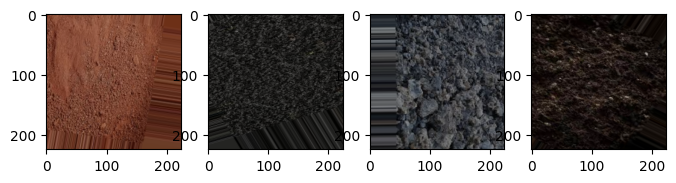

In [23]:
def plot_images(generator):
    fig = plt.figure(figsize=(8, 8))
    columns = 4
    rows = 1
    for i in range(1, columns*rows +1):
        img, label = generator.next()
        fig.add_subplot(rows, columns, i)
        plt.imshow(img[0])
    plt.show()

# augmented images from training generator
plot_images(train_gen)

# Model Building

In [12]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.applications import InceptionV3, ResNet50V2, DenseNet121


EPOCHS = 10

def create_model(model_name, classes, verbose=False):
    """
    Create and compile a CNN model for image classification using the specified architecture.
    Args:
        model_name (str): Name of the CNN architecture to use.
        classes (list): List of class names for the classification task.
        verbose (bool): Whether to print model summary.
    Returns:
        model (Sequential): Compiled CNN model with a dense output layer for classification.
    """

    # Load the specified model pre-trained on ImageNet
    if model_name == 'resnet':
        base_model = ResNet50V2(include_top=False, input_shape=(224, 224, 3))
    elif model_name == 'inception':
        base_model = InceptionV3(include_top=False, input_shape=(224, 224, 3))
    elif model_name == 'densenet':
        base_model = DenseNet121(include_top=False, input_shape=(224, 224, 3))
    elif model_name == 'mobilenet':
        base_model = MobileNetV2(include_top=False, input_shape=(224, 224, 3))
    # Freeze all layers in the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Add dense and dropout layers for classification
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    predictions = Dense(len(classes), activation='softmax')(x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Print model summary if verbose is True
    if verbose:
        model.summary()

    return model


def train(model_name, train_gen, val_gen, classes, epochs=50, verbose=False):
    """
    Trains a CNN model for image classification using the specified architecture.
    Args:
        model_name (str): Name of the CNN architecture to use.
        train_gen (DirectoryIterator): Training data generator.
        val_gen (DirectoryIterator): Validation data generator.
        classes (list): List of class names for the classification task.
        epochs (int): Number of training epochs.
    Returns:
        history (History): Training history of the model.
    """
    # Create the specified CNN model
    model = create_model(model_name=model_name, classes=classes, verbose=verbose)

    def lr_scheduler(epoch, lr):
        if epoch < 10:
            return lr
        else:
            return lr * tf.math.exp(-0.1)

    lr_schedule = LearningRateScheduler(lr_scheduler, verbose=1)
    callbacks = [lr_schedule]

    # Compile model
    optimizer = Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Fit model
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )

    # save trained model
    model.save(f'./saved_models/soil_type_identification_{model_name}_model.h5')
    return history

### Accuracy Loss curve

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

def accuracy_loss_curve(history):
    # Accuracy curve
    sns.set_style('darkgrid')
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
    plt.show()

    # Loss curve
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
    plt.show()

## MobileNet Model

In [3]:
m_net_hist = train(
    model_name='mobilenet',
    train_gen=train_gen,
    val_gen=validation_gen,
    classes=CLASSES,
    epochs=EPOCHS
)

NameError: name 'train_gen' is not defined

#### Accuracy Loss curve for MobileNet

In [ ]:
accuracy_loss_curve(history=m_net_hist)

## ResNet Model

In [ ]:
resnet_hist = train(
    model_name='resnet',
    train_gen=train_gen,
    val_gen=validation_gen,
    classes=CLASSES,
    epochs=EPOCHS
)

#### Accuracy Loss curve for ResNet

In [6]:
accuracy_loss_curve(history=resnet_hist)

NameError: name 'resnet_hist' is not defined

## Inception Model

In [ ]:
inception_hist = train(
    model_name='inception',
    train_gen=train_gen,
    val_gen=validation_gen,
    classes=CLASSES,
    epochs=EPOCHS
)

#### Accuracy Loss curve for Inception

In [ ]:
accuracy_loss_curve(history=inception_hist)

## DenseNet Model

In [ ]:
densenet_hist = train(
    model_name='densenet',
    train_gen=train_gen,
    val_gen=validation_gen,
    classes=CLASSES,
    epochs=EPOCHS
)

#### Accuracy Loss curve for DenseNet

In [ ]:
accuracy_loss_curve(history=densenet_hist)

# Custom Model Building

In [24]:
from tensorflow.keras import regularizers

def create_model():
    model = Sequential()
    model.add(Conv2D(32,(3,3),input_shape=(224,224,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Flatten())
    model.add(Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(len(CLASSES), activation="softmax"))

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [25]:
model = create_model()

In [26]:
def train(train_gen, val_gen, epochs=10):
    hist = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        verbose=1
    )
    return hist

hist = train(train_gen, validation_gen, 10)

Epoch 1/10
2/2 [==============================] - 7s 4s/step - loss: 9.1848 - accuracy: 0.1667 - val_loss: 8.9404 - val_accuracy: 0.2000
Epoch 2/10
2/2 [==============================] - 5s 2s/step - loss: 8.8539 - accuracy: 0.1825 - val_loss: 8.5938 - val_accuracy: 0.3667
Epoch 3/10
2/2 [==============================] - 5s 2s/step - loss: 8.5310 - accuracy: 0.3492 - val_loss: 8.2803 - val_accuracy: 0.3333
Epoch 4/10
2/2 [==============================] - 5s 2s/step - loss: 8.2125 - accuracy: 0.3651 - val_loss: 7.9667 - val_accuracy: 0.3667

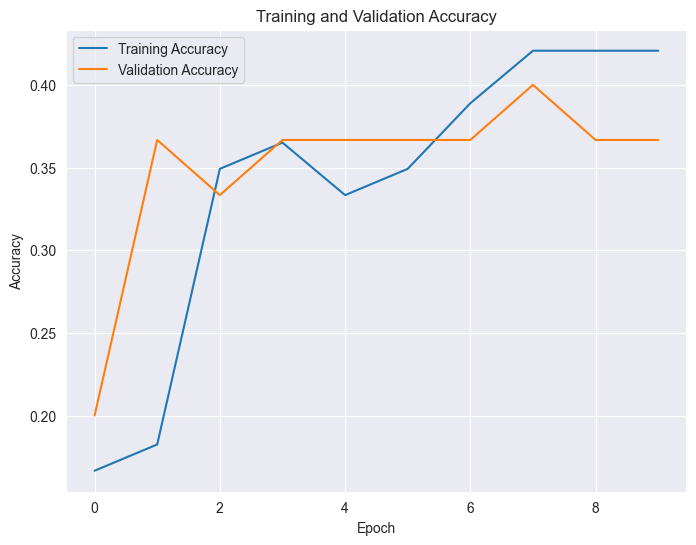

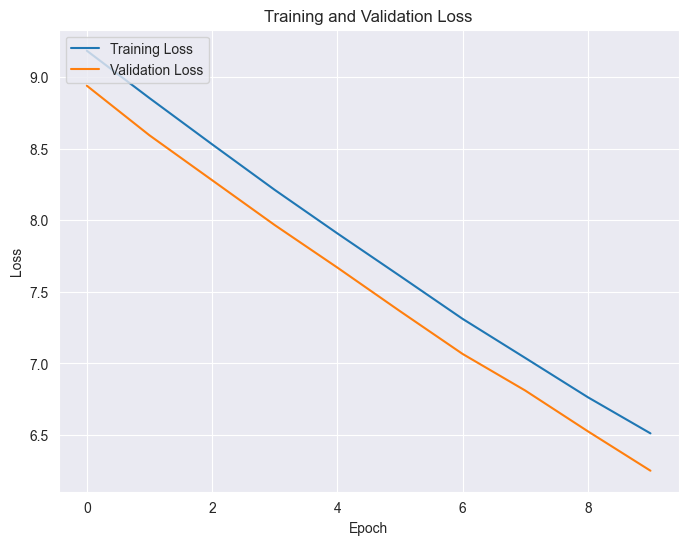

In [27]:
# accuracy curve
accuracy_loss_curve(hist)

# Save Model

In [28]:
model.save('./saved_models/soil_type_identification_model.h5')

In [29]:
model.save('./saved_models/soil_type_identification_model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./saved_models/soil_type_identification_model\assets


# Test Run

## diseases_check_trained_model

In [30]:
# loading model

loaded_model = load_model('./saved_models/soil_type_identification_model.h5')

In [31]:
img_path = './dataset/soil_types/Black Soil/2.jpg'

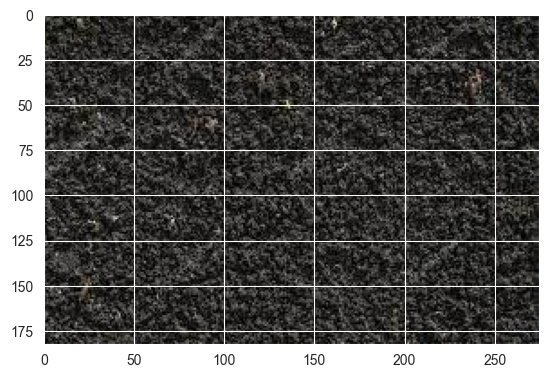

In [32]:
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow
%matplotlib inline
testim = mpimg.imread(img_path)
imshow(testim)

In [33]:
import cv2

def get_processed_input_img(image_path, size=224):
  test_img = cv2.imread(image_path)
  test_img = cv2.resize(test_img, dsize=(size, size), interpolation=cv2.INTER_AREA)

  test_img = test_img.reshape((1, size, size, 3)).astype(np.float32)

  return test_img/225

In [34]:
processed_img = get_processed_input_img(img_path)

In [35]:
pred = loaded_model.predict(processed_img)
print(pred)

[[0.30802837 0.4203261  0.01661628 0.18739723 0.06763203]]


In [36]:
# inversely sorted array with indexes
best_idx = (-pred).argsort()[0]
print(best_idx)
# output
# [0.300135, 0.32547, 0.28438]
# [1, 0, 2]   <--- array element indexes for the results

[1 0 3 4 2]


In [37]:
# to textual form
print([CLASSES[i] for i in best_idx])

['Cinder Soil', 'Black Soil', 'Peat Soil', 'Yellow Soil', 'Laterite Soil']


In [38]:
for i in best_idx:
  print('{} probability: {}'.format(CLASSES[i], pred[0][i]))




Cinder Soil probability: 0.4203261137008667
Black Soil probability: 0.30802837014198303
Peat Soil probability: 0.18739722669124603
Yellow Soil probability: 0.0676320344209671
Laterite Soil probability: 0.016616275534033775
